# Using data from AWS with intake_esm

A significant amount of Earth System Model (ESM) data is publicly available online, including data from the CESM Large Ensemble, CMIP5, and CMIP6 datasets. For accessing a single file, we can specify the file (typically netcdf or zarr format) and its location and then use fsspec (the "Filesystem Spec+  python package) and xarray  to create a array.dataset.  For several files, the intake_esm python module (https://github.com/intake/intake-esm) is particulary nice for obtaining the data and put it into an xarray.dataset.

This notebook assumes familiarity with the Tutorial Notebook.  It additionally shows how to gather data from an ESM collection, put it into a dataset, and then create simple plots using the data with ldcpy.

#### Example Data

The example data we use is from the CESM Large Ensemble, member 31. This ensemble data has been lossily compressed and reconstructed as part of a blind evaluation study of lossy data compression in LENS (e.g., http://www.cesm.ucar.edu/projects/community-projects/LENS/projects/lossy-data-compression.html or https://gmd.copernicus.org/articles/9/4381/2016/).

Most of the data from the CESM Large Ensemble Project has been made available on Amazon Web Services (Amazon S3), see http://ncar-aws-www.s3-website-us-west-2.amazonaws.com/CESM_LENS_on_AWS.htm .

For comparison purposes, the original (non-compressed) data for Ensemble 31 has recently been made available on Amazon Web Services (Amazon S3)  in the "ncar-cesm-lens-baker-lossy-compression-test" bucket,.

In [1]:
# Add ldcpy root to system path
import sys
sys.path.insert(0,'../../../')

# Import ldcpy package
# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
%load_ext autoreload
%autoreload 2
import ldcpy

import intake
import fsspec
import xarray as xr

#display the plots in this notebook
%matplotlib inline

## Method 1: using fsspec and xr.open_zarr

First, specify the filesystem and location of the data.  Here we are accessing the original data from CESM-LENS ensemble 31, which is available on Amazon S3 in the store named _"ncar-cesm-lens-baker-lossy-compression-test"_ bucket.

First we listing all available files (which are timeseries files containing a single variable) for that dataset. Note that unlike in the TutorialNotebook (which used NetCDF files), these files are all zarr format. Both monthly and daily data is available.

In [2]:
fs = fsspec.filesystem('s3', anon=True)
stores = fs.ls("ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/")[1:]
stores[:]

['ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FLNS.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FLNSC.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FLUT.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FSNS.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FSNSC.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FSNTOA.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-ICEFRAC.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-LHFLX.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-PRECL.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-PRECSC.zarr',
 'ncar-cesm-lens-baker-lossy-

Then we select the file from the store that we want and open it as an xarray.Dataset using xr.open_zarr(). Here we grab data for the first 2D daily variable, FLNS (net longwave flux at surface, in $W/m^2$), in the list (accessed by it location -- stores[0]).

In [3]:
store = fs.get_mapper(stores[0])
ds_flns = xr.open_zarr(store, consolidated=True, decode_times=False)
ds_flns

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 31391)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) float64 0.0 1.0 2.0 3.0 ... 3.139e+04 3.139e+04 3.139e+04
Dimensions without coordinates: nbnd
Data variables:
    FLNS       (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
    time_bnds  (time, nbnd) float64 dask.array<chunksize=(15696, 2), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    Version:          $Name$
    case:             b.e11.B20TRC5CNBDRD.f09_g16.031
    host:             ys0219
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01-00000.nc
    logname:          mickelso
    revision_Id:      $Id$
    source:           CAM
    title:            UNSET
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

The above returned an xarray.Dataset, and we can now easily plot the mean (of FLNS) over the first 5 days with ldcpy.plot:

**ALEX - what is the meaning of the label for set1 when we didn't open with open_dataset...It seems like it is now the variable name?**

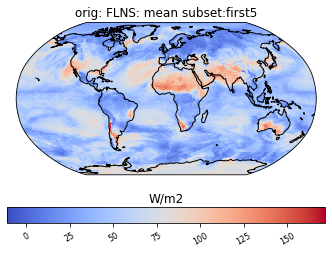

In [34]:
ldcpy.plot(ds_flns, "FLNS", set1='orig', metric='mean', subset='first5')

Now let's grab the TMQ (Total vertically integrated precipitatable water) data and plot the mean over the first 5 days

In [25]:
#TMQ data
store2 = fs.get_mapper(stores[16])
ds_tmq = xr.open_zarr(store2, consolidated=True, decode_times=False)
ds_tmq

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 31391)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) float64 0.0 1.0 2.0 3.0 ... 3.139e+04 3.139e+04 3.139e+04
Dimensions without coordinates: nbnd
Data variables:
    TMQ        (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
    time_bnds  (time, nbnd) float64 dask.array<chunksize=(15696, 2), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    Version:          $Name$
    case:             b.e11.B20TRC5CNBDRD.f09_g16.031
    host:             ys0219
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01-00000.nc
    logname:          mickelso
    revision_Id:      $Id$
    source:           CAM
    title:            UNSET
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

In [ ]:
#plot TMQ mean (5 days)
ldcpy.plot(ds_tmq, "TMQ", set1='orig', metric='mean', subset='first5')

In [6]:
#TS data
store3 = fs.get_mapper(stores[20])
ds_ts = xr.open_zarr(store3, consolidated=True, decode_times=False)
ds_ts

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 31391)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) float64 0.0 1.0 2.0 3.0 ... 3.139e+04 3.139e+04 3.139e+04
Dimensions without coordinates: nbnd
Data variables:
    TS         (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
    time_bnds  (time, nbnd) float64 dask.array<chunksize=(15696, 2), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    Version:          $Name$
    case:             b.e11.B20TRC5CNBDRD.f09_g16.031
    host:             ys0219
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01-00000.nc
    logname:          mickelso
    revision_Id:      $Id$
    source:           CAM
    title:            UNSET
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

In [ ]:
#plot TS mean
ldcpy.plot(ds_ts, "TS", set1='orig', metric='mean', subset='first5')

## Method 2: Using intake_esm

Now we will demonstrate using the intake_esm module.  We can use the intake_esm module to search for and open several files as xarray.Dataset objects. Then we can use ldcpy as before. The code below is modified from the intake_esm documentation, available here: https://intake-esm.readthedocs.io/en/latest/?badge=latest#overview.

We will now use ensemble 31 data from the CEMS LENS collection on AWS, which (as explained above) has been subjected to lossy compression. Many catalogs for publicly available datasets are accessible via intake-esm can be found at https://github.com/NCAR/intake-esm-datastore/tree/master/catalogs, including for CESM-LENS. We can open that collection as follows (see here: https://github.com/NCAR/esm-collection-spec/blob/master/collection-spec/collection-spec.md#attribute-object): 

In [7]:
col_loc = "https://raw.githubusercontent.com/NCAR/cesm-lens-aws/master/intake-catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(col_loc)
col

,unique
component,5
frequency,5
experiment,6
variable,75
path,365


Next, we search for the subset of the collection (dataset and variables) that we are interested in.  Let's grab FLNS, TS, and PRECT daily data from the atm component (availble data is also listed here: http://ncar-aws-www.s3-website-us-west-2.amazonaws.com/CESM_LENS_on_AWS.htm)

In [22]:
#we want daily data for FLNS, TMQ, and TS
aws_col_subset = col.search(component='atm', frequency='daily', experiment='20C',
                        variable=["FLNS", "TS", "TMQ"])
#display header info
aws_col_subset.df.head()

,component,frequency,experiment,variable,path
0,atm,daily,20C,FLNS,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-FLNS....
1,atm,daily,20C,TMQ,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-TMQ.zarr
2,atm,daily,20C,TS,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-TS.zarr


Then we load matching catalog entries into xarray datasets (https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict):



In [30]:
dset_dict = aws_col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True, "decode_times": True}, 
                                   storage_options={"anon": True})
dset_dict

{'atm.20C.daily': <xarray.Dataset>
 Dimensions:    (lat: 192, lon: 288, member_id: 40, nbnd: 2, time: 56940)
 Coordinates:
   * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
   * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
   * time       (time) object 1850-01-01 00:00:00 ... 2005-12-31 00:00:00
 Dimensions without coordinates: nbnd
 Data variables:
     FLNS       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 576, 192, 288), meta=np.ndarray>
     time_bnds  (time, nbnd) object dask.array<chunksize=(576, 2), meta=np.ndarray>
     TMQ        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 576, 192, 288), meta=np.ndarray>
     TS         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 576, 192, 288), meta=np.ndarray>
 Attributes:
     title:                     UNSET
     important_note:            This data is 

Check the dataset keys to ensure that the dataset we want is present:

In [32]:
dset_dict.keys()

dict_keys(['atm.20C.daily'])

Finally, put the values we are interested from the dictionary into their own dataset variable:

In [33]:
aws_ds=(dsets['atm.20C.daily'])
aws_ds

,Array,Chunk
Bytes,503.77 GB,127.40 MB
Shape,"(40, 56940, 192, 288)","(1, 576, 192, 288)"
Count,3961 Tasks,3960 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,911.04 kB,9.22 kB
Shape,"(56940, 2)","(576, 2)"
Count,100 Tasks,99 Chunks
Type,object,numpy.ndarray
,Array,Chunk


## Now compare the orig data to the lossy compressed data

I don't know how to do this since they are in different data sets - I want to compare FLNS from ds_flns to FLNS in the aws_ds..

## Make your own catalog

**in progress**

We created a test_catalog.csv and test_collection.json file for this particular simple examples.

Then we load matching catalog entries into xarray datasets (https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict):

In [ ]:
#ldcpy.plot(aws_ds, "ICEFRAC", set1='orig', metric='mean', subset='first5')

In [ ]:
#ldcpy.plot(aws_ds, "PRECT", set1='orig', metric='mean', subset='first5')

In [ ]:
#ldcpy.plot(aws_ds, "FLUT", set1='orig', metric='mean', subset='first5')